#### Top

# Chapter 4 Aggregation with Polars

* [4.0 Imports and Setup](#4.0-Imports-and-Setup)
* [4.1 Introduction](#4.1-Introduction)
* [4.2 Loading the Data](#4.2-Loading-the-Data)
* [4.3 Aggregations](#4.3-Aggregations)
* [4.4 Lists](#4.4-Lists)
  - [4.4.1 Using `.with_columns_seq`](#4.4.1-Using-.with_columns_seq)
* [4.5 GroupBy Operations](#4.5-GroupBy-Operations)
* [4.6 Multiple Aggregations](#4.6-Multiple-Aggregations)
* [4.7 Grouping by Multiple Columns](#4.7-Grouping-by-Multiple-Columns)
* [4.8 Pivoting with Multiple Aggregations](#4.8-Pivoting-with-Multiple-Aggregations)
* [4.9 Aggregating over the Original Rows](#4.9-Aggregating-over-the-Original-Rows)
* [4.10 Grouping to Lists](#4.10-Grouping-to-Lists)
* [4.11 Chapter Methods and Functions](#4.11-Chapter-Methods-and-Functions)


---
# 4.0 Imports and Setup

[back to Top](#Top)

In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import chardet
import pprint as pp
import hvplot.polars
hvplot.extension('matplotlib')

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
pd.options.mode.copy_on_write = True
print(pd.options.mode.copy_on_write)
pl.Config.set_verbose(True)
pl.show_versions()

def HR():
    print("-"*40)

@pl.Config(tbl_cols=-1, ascii_tables=True)
def tight_layout(df: pl.DataFrame, n=5) -> None:
    with pl.Config(tbl_cols=-1, fmt_str_lengths=n):
        print(df)

def detect_encoding(filename: str) -> str:
    """Return the most probable character encoding for a file."""
    with open(filename, "rb") as f:
        raw_data = f.read()
        print(raw_data)
        result = chardet.detect(raw_data)
        return result["encoding"]

True
--------Version info---------
Polars:              1.9.0
Index type:          UInt32
Platform:            macOS-12.7.6-x86_64-i386-64bit
Python:              3.11.5 (main, Jan 16 2024, 17:25:53) [Clang 14.0.0 (clang-1400.0.29.202)]

----Optional dependencies----
adbc_driver_manager  1.1.0
altair               5.4.0
cloudpickle          3.0.0
connectorx           0.3.3
deltalake            0.19.1
fastexcel            0.11.6
fsspec               2023.12.2
gevent               24.2.1
great_tables         0.10.0
matplotlib           3.9.2
nest_asyncio         1.6.0
numpy                2.0.2
openpyxl             3.1.5
pandas               2.2.2
pyarrow              17.0.0
pydantic             2.8.2
pyiceberg            0.6.1
sqlalchemy           2.0.32
torch                <not installed>
xlsx2csv             0.8.3
xlsxwriter           3.2.0


---
# 4.1 Introduction
[back to Top](#Top)

One of the most common tasks in data analysis is aggregation and grouping operations on datasets.

This is especially true for large datasets, where summarizing and aggregating data is often necessary to gain insights and make sense of information.

---
# 4.2 Loading the Data
[back to Top](#Top)

Use the Fuel Economy dataset

In [2]:
path = 'data/vehicles.csv'
raw = pl.read_csv(path, null_values=['NA'])
print(raw.shape)
print(f"{raw.estimated_size(unit='mb'):.2f}MB")

@pl.StringCache()
def tweak_auto(df):
    cols = ['year', 'make', 'model', 'displ', 'cylinders', 'trany', 
           'drive', 'VClass', 'fuelType', 'barrels08', 'city08', 
           'highway08', 'createdOn']
    return (
        df
        .select(pl.col(cols))
        .with_columns( 
            pl.col('year').cast(pl.Int16),
            pl.col(['cylinders', 'highway08', 'city08']).cast(pl.UInt8),
            pl.col(['displ', 'barrels08']).cast(pl.Float32),
            pl.col(['make', 'model', 'VClass', 'drive', 'fuelType']).cast(pl.Categorical),
            pl.col('createdOn').str.to_datetime('%a %b %d %H:%M:%S %Z %Y'),
            pl.col('trany')                    
               .str.contains('Automatic')
               .fill_null('Automatic').alias('is_automatic'),
            pl.col('trany')
                .str.extract(r'(\d+)')
                .cast(pl.UInt8)
                .fill_null(6).alias('num_gears'),
        )
    )

autos = tweak_auto(raw)
print(type(autos))
print(autos.shape)
print(f"{autos.estimated_size(unit='mb'):.2f}MB")

avg line length: 434.78027
std. dev. line length: 23.885818
initial row estimate: 47850
no. of chunks: 4 processed by: 4 threads.


(48202, 84)
29.34MB
<class 'polars.dataframe.frame.DataFrame'>
(48202, 15)
2.94MB


In [3]:
autos.flags

{'year': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'make': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'model': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'displ': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'cylinders': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'trany': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'drive': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'VClass': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'fuelType': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'barrels08': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'city08': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'highway08': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'createdOn': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'is_automatic': {'SORTED_ASC': False, 'SORTED_DESC': False},
 'num_gears': {'SORTED_ASC': False, 'SORTED_DESC': False}}

In [4]:
{col:autos[col].is_sorted() for col in autos.columns}

{'year': False,
 'make': False,
 'model': False,
 'displ': False,
 'cylinders': False,
 'trany': False,
 'drive': False,
 'VClass': False,
 'fuelType': False,
 'barrels08': False,
 'city08': False,
 'highway08': False,
 'createdOn': False,
 'is_automatic': False,
 'num_gears': False}

---
# 4.3 Aggregations
[back to Top](#Top)


In [5]:
col = pl.col('make')
print(sorted([att for att in dir(col) if not att.startswith('_')]))

['abs', 'add', 'agg_groups', 'alias', 'all', 'and_', 'any', 'append', 'approx_n_unique', 'arccos', 'arccosh', 'arcsin', 'arcsinh', 'arctan', 'arctanh', 'arg_max', 'arg_min', 'arg_sort', 'arg_true', 'arg_unique', 'arr', 'backward_fill', 'bin', 'bitwise_and', 'bitwise_count_ones', 'bitwise_count_zeros', 'bitwise_leading_ones', 'bitwise_leading_zeros', 'bitwise_or', 'bitwise_trailing_ones', 'bitwise_trailing_zeros', 'bitwise_xor', 'bottom_k', 'bottom_k_by', 'cast', 'cat', 'cbrt', 'ceil', 'clip', 'cos', 'cosh', 'cot', 'count', 'cum_count', 'cum_max', 'cum_min', 'cum_prod', 'cum_sum', 'cumulative_eval', 'cut', 'degrees', 'deserialize', 'diff', 'dot', 'drop_nans', 'drop_nulls', 'dt', 'entropy', 'eq', 'eq_missing', 'ewm_mean', 'ewm_mean_by', 'ewm_std', 'ewm_var', 'exclude', 'exp', 'explode', 'extend_constant', 'fill_nan', 'fill_null', 'filter', 'first', 'flatten', 'floor', 'floordiv', 'forward_fill', 'from_json', 'gather', 'gather_every', 'ge', 'get', 'gt', 'has_nulls', 'hash', 'head', 'hist'

---
Experiment using some aggregation functions on the autos `comb08` column.

In [6]:
sorted(autos.columns)

['VClass',
 'barrels08',
 'city08',
 'createdOn',
 'cylinders',
 'displ',
 'drive',
 'fuelType',
 'highway08',
 'is_automatic',
 'make',
 'model',
 'num_gears',
 'trany',
 'year']

* Using `.select()` creates a *new* dataframe with new columns.
* Using `.with_columns()` appends a new columns to the original dataframe.

In [7]:
city = pl.col('city08')

test = (
    autos
    .select(
        mean_city=city.mean(),
        std_city=city.std(),
        var_city=city.var(),
        q99_city=city.quantile(.99)
    )
)
test

mean_city,std_city,var_city,q99_city
f64,f64,f64,f64
19.929235,12.658018,160.225423,95.0


If we add a new aggregated column to an existing dataframe, the column will be appended to the right of the existing columns.

In [8]:
(
    autos
    .with_columns(mean_city=city.mean())
    .head(2)
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears,mean_city
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8,f64
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""false""",5,19.929235
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01 00:00:00,"""false""",5,19.929235


In [9]:
# contrast to .select()
(
    autos
    .select(mean_city=city.mean())
    .head(2)
)

mean_city
f64
19.929235


---
# 4.4 Lists
[back to Top](#Top)

* Polars can have typed lists in a column.
* Polars stores the lists as typed arrays.
* This allows Polars to **perform operations on the lists in a vectorized manner**.
* Polars list operations are methods found on the column `.list` attribute

*Example:*
* We have columns of student test scores and want to drop the two lowest scores for each student.
* There is not easy way to do this with columns.
* However, we can combine the test columns into a single column of lists.
* Then, we use list operations to sort the list and remove the two lowest values.
* Finally we sort the list.

In [10]:
tests = pl.DataFrame({
    'name':['Tom', 'Sally', 'Jose'],
    'test1':[99, 98, 95],
    'test2':[92, None, 99],
    'test3':[91, 93, 95],
    'test4':[94, 92, 99]
})
print(tests)

shape: (3, 5)
+-------+-------+-------+-------+-------+
| name  | test1 | test2 | test3 | test4 |
| ---   | ---   | ---   | ---   | ---   |
| str   | i64   | i64   | i64   | i64   |
+=======================================+
| Tom   | 99    | 92    | 91    | 94    |
| Sally | 98    | null  | 93    | 92    |
| Jose  | 95    | 99    | 95    | 99    |
+-------+-------+-------+-------+-------+


Next, create a dataframe with a column for each step

**Since each of the columns depends on the previous column, we need to put them in their own `.with_column` call, otherwise Polars would try to evaluate the columns in parallel.**

* First column: Combine the test scores into a list with `pl.concat_list()` and name the column `scores`.
* Next column: Use the `.list` attribute, which has `.sort()`, to sort values in each cell in the column.
* Next column: Use `.slice()` to remove the two lowest values.
* Final column: Sum up the list to get the total score for each student.


In [11]:
import polars.selectors as cs

In [12]:
# step 1
(
    tests
    .select(scores=pl.concat_list(cs.matches(r'test\d+')))
)

scores
list[i64]
"[99, 92, … 94]"
"[98, null, … 92]"
"[95, 99, … 99]"


In [13]:
# step 2
(
    tests
    .select(scores=pl.concat_list(cs.matches(r'test\d+')))
    .with_columns(sorted_scores=pl.col('scores').list.sort()) # 1
)

scores,sorted_scores
list[i64],list[i64]
"[99, 92, … 94]","[91, 92, … 99]"
"[98, null, … 92]","[null, 92, … 98]"
"[95, 99, … 99]","[95, 95, … 99]"


In [14]:
# step 3
(
    tests
    .select(scores=pl.concat_list(cs.matches(r'test\d+')))
    .with_columns(sorted_scores=pl.col('scores').list.sort()) # 1
    .with_columns(slice_scores=pl.col('sorted_scores').list.slice(2,4)) #2
)

scores,sorted_scores,slice_scores
list[i64],list[i64],list[i64]
"[99, 92, … 94]","[91, 92, … 99]","[94, 99]"
"[98, null, … 92]","[null, 92, … 98]","[93, 98]"
"[95, 99, … 99]","[95, 95, … 99]","[99, 99]"


In [15]:
# step 4
(
    tests
    .select(scores=pl.concat_list(cs.matches(r'test\d+')))
    .with_columns(sorted_scores=pl.col('scores').list.sort()) # 1
    .with_columns(slice_scores=pl.col('sorted_scores').list.slice(2,4)) #2
    .with_columns(sum_scores=pl.col('slice_scores').list.sum())
)

scores,sorted_scores,slice_scores,sum_scores
list[i64],list[i64],list[i64],i64
"[99, 92, … 94]","[91, 92, … 99]","[94, 99]",193
"[98, null, … 92]","[null, 92, … 98]","[93, 98]",191
"[95, 99, … 99]","[95, 95, … 99]","[99, 99]",198


---
## 4.4.1 Using `.with_columns_seq`
[back to Top](#Top)

In Polars, `with_columns_seq` and `with_columns` are both methods used to add columns to a DataFrame or LazyFrame, but they have some key differences:

Execution Order

**with_columns:**
- Executes expressions in parallel
- Each expression is unaware of other expressions in the same context

**with_columns_seq:**
- Executes expressions sequentially
- Designed for cases where the work per expression is cheap

Behavior with New Columns

**with_columns:**
- Cannot reference newly created columns within the same method call

**with_columns_seq:**
- Still does not allow referencing newly created columns within the same call
- Constructs the new DataFrame after all expressions have been computed[3]



In [16]:
# Explicit sequential operation
(
    tests
    .select(scores=pl.concat_list(cs.matches(r'test\d+')))
    .with_columns_seq(sorted_scores=pl.col('scores').list.sort()) # 1
    .with_columns_seq(slice_scores=pl.col('sorted_scores').list.slice(2,4)) #2
    .with_columns_seq(sum_scores=pl.col('slice_scores').list.sum())
)

scores,sorted_scores,slice_scores,sum_scores
list[i64],list[i64],list[i64],i64
"[99, 92, … 94]","[91, 92, … 99]","[94, 99]",193
"[98, null, … 92]","[null, 92, … 98]","[93, 98]",191
"[95, 99, … 99]","[95, 95, … 99]","[99, 99]",198


---
Selecting Columns

We can `.exclude` to rewrite the previous example

In [17]:
(
    tests
    .select(pl.all().exclude('name'))
)

test1,test2,test3,test4
i64,i64,i64,i64
99,92,91,94
98,null,93,92
95,99,95,99


We can also use *set difference* to start with all of the columns and remove the *name* column.

For this, we cannot use the expression syntax directly. We have to use `cs.all()` to use set operations.

In [18]:
try:
    print(tests.select(pl.all() - pl.col('name')))
except Exception as e:
    print(e)

arithmetic on string and numeric not allowed, try an explicit cast first

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'select' <---
 SELECT [[(col("name")) - (col("name"))], [(col("test1")) - (col("name"))], [(col("test2")) - (col("name"))], [(col("test3")) - (col("name"))], [(col("test4")) - (col("name"))]] FROM
  DF ["name", "test1", "test2", "test3"]; PROJECT */5 COLUMNS; SELECTION: None


In [19]:
# Using cs.all for set operations
import polars.selectors as cs

# tests.select(cs.all() - pl.col('name'))

In [20]:
# check
tests.select(pl.all())

name,test1,test2,test3,test4
str,i64,i64,i64,i64
"""Tom""",99,92,91,94
"""Sally""",98,null,93,92
"""Jose""",95,99,95,99


In [21]:
tests.select(cs.all())

name,test1,test2,test3,test4
str,i64,i64,i64,i64
"""Tom""",99,92,91,94
"""Sally""",98,null,93,92
"""Jose""",95,99,95,99


We can also use `cs.starts_with` to filter the columns

In [22]:
tests.select(cs.starts_with('test'))

test1,test2,test3,test4
i64,i64,i64,i64
99,92,91,94
98,null,93,92
95,99,95,99


If we want to calculate horizontal aggregations, we can also use the list functionality.

Here, calculate the maximum test score for each student.

In [23]:
tests.columns

['name', 'test1', 'test2', 'test3', 'test4']

In [24]:
(
    tests
    .select(scores=pl.concat_list(cs.starts_with('test')))
    .with_columns(max=pl.col('scores').list.max())
)

scores,max
list[i64],i64
"[99, 92, … 94]",99
"[98, null, … 92]",98
"[95, 99, … 99]",99


---
# 4.5 GroupBy Operations
[back to Top](#Top)

Grouping is a general term for a class of operations that involves:

* Splitting up a dataset based on some criteria.
* Applying a function to each group independently.
* Combining the results into a data structure.

In this example, we do a basic group-by operation on the *make* column. 

* Group the data by the *make* column, using `.group_by()`
* Calculate each group's average *city08* value, using `.agg()` on the result of the groupby.

In [25]:
(
    autos
    .group_by('make')
)

* Use a column expression to create the aggregation.
* Use `.mean()` on the *comb08* column.

In [26]:
(
    autos
    .group_by('make')
    .agg(mean_city=pl.col('city08').mean())
)

known unique values: 145
run PARTITIONED HASH AGGREGATION


make,mean_city
cat,f64
"""Lamborghini""",10.662577
"""STI""",15.0
"""Jaguar""",17.97037
"""Autokraft Limited""",14.0
"""Ruf Automobile Gmbh""",11.0
…,…
"""Audi""",20.760091
"""CODA Automotive""",77.0
"""Superior Coaches Div E.p. Dutt…",10.0


* A `maintain_order` parameter can be set to True when calling `.group_by()`.
* This maintains the order of the data.
* Here, the output will be in the order that the *make* values were in the original data.

In [27]:
(
    autos
    .group_by('make', maintain_order=True)
    .agg(mean_city=pl.col('city08').mean())
)

known unique values: 145
run PARTITIONED HASH AGGREGATION


make,mean_city
cat,f64
"""Alfa Romeo""",19.402062
"""Ferrari""",11.842294
"""Dodge""",15.461967
"""Subaru""",21.130306
"""Toyota""",22.4
…,…
"""General Motors""",15.0
"""Consulier Industries Inc""",18.0
"""Goldacre""",16.0


We can use `.sort()` to sort the data by the *make* column.

In [28]:
(
    autos
    .group_by('make')
    .agg(mean_city=pl.col('city08').mean())
    .sort('make')
)

known unique values: 145
run PARTITIONED HASH AGGREGATION


make,mean_city
cat,f64
"""Alfa Romeo""",19.402062
"""Ferrari""",11.842294
"""Dodge""",15.461967
"""Subaru""",21.130306
"""Toyota""",22.4
…,…
"""Quantum Technologies""",19.0
"""London Taxi""",21.0
"""Excalibur Autos""",12.0


The make column is not alphabetically sorted, becuase the make column is a categorical columnn, and the categories are sorted by the order in which they appear in the original dataframe.

We can specify the ordering when casting to pl.Categorical. 

In [29]:
# test
(
    autos
    .with_columns(pl.col('make').cast(pl.Categorical('lexical')))
    .sort('make')
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
1985,"""AM General""","""Post Office DJ5 2WD""",2.5,4,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Special Purpose Vehicle 2WD""","""Regular""",18.594376,16,17,2013-01-01 00:00:00,"""true""",3
1985,"""AM General""","""Post Office DJ8 2WD""",4.2,6,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Special Purpose Vehicle 2WD""","""Regular""",22.885386,13,13,2013-01-01 00:00:00,"""true""",3
1984,"""AM General""","""FJ8c Post Office""",4.2,6,"""Automatic 3-spd""","""2-Wheel Drive""","""Special Purpose Vehicle 2WD""","""Regular""",22.885386,13,13,2013-01-01 00:00:00,"""true""",3
1984,"""AM General""","""DJ Po Vehicle 2WD""",2.5,4,"""Automatic 3-spd""","""2-Wheel Drive""","""Special Purpose Vehicle 2WD""","""Regular""",17.500587,18,17,2013-01-01 00:00:00,"""true""",3
1984,"""AM General""","""FJ8c Post Office""",4.2,6,"""Automatic 3-spd""","""2-Wheel Drive""","""Special Purpose Vehicle 2WD""","""Regular""",22.885386,13,13,2013-01-01 00:00:00,"""true""",3
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2017,"""smart""","""fortwo electric drive converti…",null,null,"""Automatic (A1)""","""Rear-Wheel Drive""","""Two Seaters""","""Electricity""",0.0792,112,91,2017-10-11 00:00:00,"""true""",1
2018,"""smart""","""fortwo electric drive coupe""",null,null,"""Automatic (A1)""","""Rear-Wheel Drive""","""Two Seaters""","""Electricity""",0.0744,124,94,2017-12-05 00:00:00,"""true""",1
2018,"""smart""","""fortwo electric drive converti…",null,null,"""Automatic (A1)""","""Rear-Wheel Drive""","""Two Seaters""","""Electricity""",0.0792,112,91,2017-12-05 00:00:00,"""true""",1


In [30]:
(
    autos
    .with_columns(pl.col('make').cast(pl.Categorical('lexical')))
    .group_by('make')
    .agg(mean_city=pl.col('city08').mean())
    .sort('make')
)

known unique values: 145
run PARTITIONED HASH AGGREGATION


make,mean_city
cat,f64
"""AM General""",15.166667
"""ASC Incorporated""",14.0
"""Acura""",20.011792
"""Alfa Romeo""",19.402062
"""American Motors Corporation""",16.296296
…,…
"""Volkswagen""",23.39819
"""Volvo""",20.320775
"""Wallace Environmental""",12.4375


---
# 4.6 Multiple Aggregations
[back to Top](#Top)

We can pass multiple expressions to `.agg()` to perform multiple aggregations. 

Here, we calculate the average and median values for both *city08* and *highway08* columns.

In [31]:
# Basic operation, using whole dataset with 15 columns
(
    autos
    .with_columns(pl.col('make').cast(pl.Categorical('lexical')))
    .group_by('make')
    .agg(
        mean_city=pl.col('city08').mean(),
        median_city=pl.col('city08').median(),
        median_highway=pl.col('highway08').median()
    )
    .sort('make')
)

keys/aggregates are not partitionable: running default HASH AGGREGATION


make,mean_city,median_city,median_highway
cat,f64,f64,f64
"""AM General""",15.166667,14.5,15.0
"""ASC Incorporated""",14.0,14.0,21.0
"""Acura""",20.011792,20.0,27.0
"""Alfa Romeo""",19.402062,19.0,25.0
"""American Motors Corporation""",16.296296,16.0,20.0
…,…,…,…
"""Volkswagen""",23.39819,21.0,28.0
"""Volvo""",20.320775,18.0,26.0
"""Wallace Environmental""",12.4375,11.0,15.0


In [32]:
# variation using .select instead of .with_columns
# and only 3 columns
(
    autos
    .select(
        pl.col('make').cast(pl.Categorical('lexical')),
        pl.col('city08'),
        pl.col('highway08')
    )
    .group_by('make')
    .agg(
        mean_city=pl.col('city08').mean(),
        median_city=pl.col('city08').median(),
        median_highway=pl.col('highway08').median()
    )
    .sort('make')
)

keys/aggregates are not partitionable: running default HASH AGGREGATION


make,mean_city,median_city,median_highway
cat,f64,f64,f64
"""AM General""",15.166667,14.5,15.0
"""ASC Incorporated""",14.0,14.0,21.0
"""Acura""",20.011792,20.0,27.0
"""Alfa Romeo""",19.402062,19.0,25.0
"""American Motors Corporation""",16.296296,16.0,20.0
…,…,…,…
"""Volkswagen""",23.39819,21.0,28.0
"""Volvo""",20.320775,18.0,26.0
"""Wallace Environmental""",12.4375,11.0,15.0


In [33]:
# variation using .select instead of .with_columns
# and pl.all() with name.suffix()
(
    autos
    .select(
        pl.col('make').cast(pl.Categorical('lexical')),
        pl.col('city08'),
        pl.col('highway08')
    )
    .group_by('make')
    .agg(
        pl.all().mean().name.suffix('_mean'),
        pl.all().min().name.suffix('_min'),
        pl.all().max().name.suffix('_max')
    )
    .sort('make')
)

known unique values: 145
run PARTITIONED HASH AGGREGATION


make,city08_mean,highway08_mean,city08_min,highway08_min,city08_max,highway08_max
cat,f64,f64,u8,u8,u8,u8
"""AM General""",15.166667,15.0,13,13,18,17
"""ASC Incorporated""",14.0,21.0,14,21,14,21
"""Acura""",20.011792,26.816038,13,17,96,83
"""Alfa Romeo""",19.402062,26.546392,11,16,29,34
"""American Motors Corporation""",16.296296,20.481481,15,17,19,23
…,…,…,…,…,…,…
"""Volkswagen""",23.39819,30.463801,11,14,126,111
"""Volvo""",20.320775,26.926803,13,19,127,104
"""Wallace Environmental""",12.4375,16.0,8,13,17,22


---
# 4.7 Grouping by Multiple Columns
[back to Top](#Top)

* We can also group by multiple columns.
* Here, we group by the *make* and *year* columns.
* We then calculate each group's average *city08* value.
* We use `.cast` to convert *make* to an alphabetically ordered category (via the 'lexical' argument)

In [34]:
(
    autos
    .with_columns(pl.col('make').cast(pl.Categorical('lexical')))
    .group_by(['make', 'year'])
    .agg(mean_city08=pl.col('city08').mean())
    .sort(['make', 'year'])
)

estimated unique values: 2223
estimated unique count: 2223 exceeded the boundary: 1000, running default HASH AGGREGATION


make,year,mean_city08
cat,i16,f64
"""AM General""",1984,15.5
"""AM General""",1985,14.5
"""ASC Incorporated""",1987,14.0
"""Acura""",1986,20.0
"""Acura""",1987,18.833333
…,…,…
"""smart""",2015,78.0
"""smart""",2016,77.0
"""smart""",2017,60.666667


---
# 4.8 Pivoting with Multiple Aggregations
[back to Top](#Top)


* `.pivot()` can only be used with a single aggregation.
* If we want to use multiple aggregations, we need to use `.group_by()` and then use `.pivot()` on the result of the groupby.

  
Here, we calculate the min and max *city08* values by year for the top-3 makes.

* First, calculate the top-three makes.
* This is akin to Pandas value counts.
* Do this by grouping by the *make* column and aggregating with `.len()`.
* We need to sort the data by the aggregated column before taking the top-3 rows.


In [35]:
# equivalent to Pandas .value_counts
top3 = (
    autos
    .group_by('make')
    .len()
    .sort(by=['len'], descending=True)
    .head(3)
)
top3

known unique values: 145
run PARTITIONED HASH AGGREGATION


make,len
cat,u32
"""Chevrolet""",4472
"""Ford""",3834
"""GMC""",2823


In [36]:
# Pandas version with value_counts()
autos_pandas = autos.to_pandas()
autos_pandas['make'].value_counts(ascending=False).head(3)

make
Chevrolet    4472
Ford         3834
GMC          2823
Name: count, dtype: int64

---
Now, we can do the groupby operation.

In [37]:
(
    autos
    .filter(pl.col('make').is_in(top3['make']))
    .group_by(['year', 'make'])
    .agg(
        src_city08=pl.col('city08').sort(),
        min_city08=pl.col('city08').min(),
        max_city08=pl.col('city08').max(),
    )
    .sort(['year', 'make'])
)

dataframe filtered
keys/aggregates are not partitionable: running default HASH AGGREGATION


year,make,src_city08,min_city08,max_city08
i16,cat,list[u8],u8,u8
1984,"""Chevrolet""","[10, 10, … 33]",10,33
1984,"""Ford""","[9, 9, … 35]",9,35
1984,"""GMC""","[10, 10, … 26]",10,26
1985,"""Chevrolet""","[9, 10, … 39]",9,39
1985,"""Ford""","[9, 10, … 36]",9,36
…,…,…,…,…
2024,"""Ford""","[10, 14, … 111]",10,111
2024,"""GMC""","[14, 14, … 59]",14,59
2025,"""Chevrolet""","[12, 12, … 102]",12,102


If we want the *make* column to be pulled into the columns, we can use `.pivot()`.

In [38]:
print(type(top3))
print(type(top3['make']))

<class 'polars.dataframe.frame.DataFrame'>
<class 'polars.series.series.Series'>


In [39]:
(
    autos
    .filter(pl.col('make').is_in(top3['make']))
    .group_by(['year', 'make'])
    .agg(
        min_city08=pl.col('city08').min(),
        max_city08=pl.col('city08').max(),
    )
    .sort(['year', 'make'])
)

dataframe filtered
estimated unique values: 5
run PARTITIONED HASH AGGREGATION


year,make,min_city08,max_city08
i16,cat,u8,u8
1984,"""Chevrolet""",10,33
1984,"""Ford""",9,35
1984,"""GMC""",10,26
1985,"""Chevrolet""",9,39
1985,"""Ford""",9,36
…,…,…,…
2024,"""Ford""",10,111
2024,"""GMC""",14,59
2025,"""Chevrolet""",12,102


In [40]:
(
    autos
    .filter(pl.col('make').is_in(top3['make']))
    .group_by(['year', 'make'])
    .agg(
        min_city08=pl.col('city08').min(),
        max_city08=pl.col('city08').max(),
    )
    .sort(['year', 'make'])
    .pivot(
        index='year',
        on='make',
        values=['min_city08', 'max_city08']
    )
)

dataframe filtered
estimated unique values: 5
run PARTITIONED HASH AGGREGATION


year,min_city08_Chevrolet,min_city08_Ford,min_city08_GMC,max_city08_Chevrolet,max_city08_Ford,max_city08_GMC
i16,u8,u8,u8,u8,u8,u8
1984,10,9,10,33,35,26
1985,9,9,9,39,36,26
1986,9,10,9,44,34,21
1987,11,10,11,44,31,20
1988,11,10,11,44,33,21
…,…,…,…,…,…,…
2021,13,12,13,127,108,25
2022,13,12,13,131,110,25
2023,12,10,14,131,110,24


---
Using Pandas for plotting.

dataframe filtered
estimated unique values: 5
run PARTITIONED HASH AGGREGATION


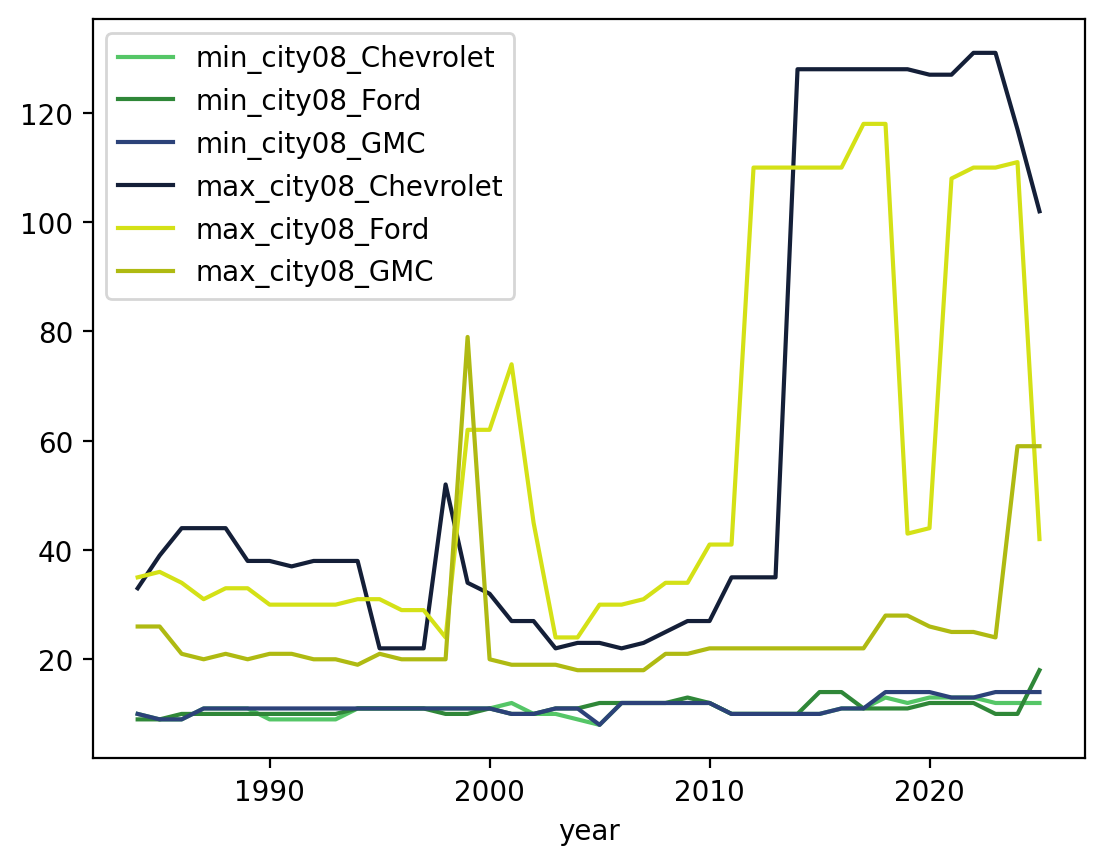

In [41]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots()

(
    autos
    .filter(pl.col('make').is_in(top3['make']))
    .group_by(['year', 'make'])
    .agg(
        min_city08=pl.col('city08').min(),
        max_city08=pl.col('city08').max(),
    )
    .sort(['year', 'make'])
    .pivot(
        index='year',
        on='make',
        values=['min_city08', 'max_city08']
    )
    .to_pandas()
    .set_index('year')
    .plot(
        ax=ax,
        color=['#55c667', '#2f8738', '#2c4279', '#141f38', '#d4e116', '#afba12']
    )
)
plt.show()

---
Using hvplot to plot in Polars.

dataframe filtered
estimated unique values: 5
run PARTITIONED HASH AGGREGATION


<class 'holoviews.core.overlay.NdOverlay'>


:NdOverlay   [Variable]
   :Curve   [year]   (value)
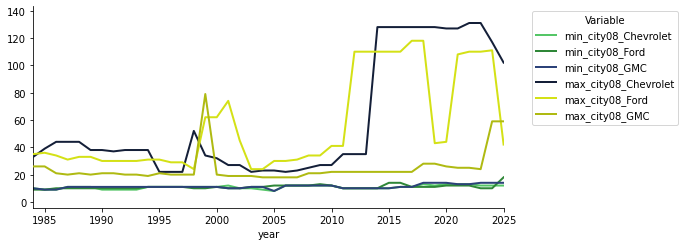

In [42]:
import hvplot.polars
hvplot.extension('matplotlib')

res = (
    autos
    .filter(pl.col('make').is_in(top3['make']))
    .group_by(['year', 'make'])
    .agg(
        min_city08=pl.col('city08').min(),
        max_city08=pl.col('city08').max(),
    )
    .sort(['year', 'make'])
    .pivot(
        index='year',
        on='make',
        values=['min_city08', 'max_city08']
    )
    .hvplot(
        x='year', # pseudo index
        color=['#55c667', '#2f8738', '#2c4279', '#141f38', '#d4e116', '#afba12']
    )
    
)

print(type(res))
res

---
# 4.9 Aggregating over the Original Rows
[back to Top](#Top)

* In Pandas, `.transform()` aggregates data and returns the aggregated values in terms of the original rows.
* There is no `.transform()` in Polars, but you can achieve the same result using the window function `.over()`

In this example:

* Calculate the *make* average *city08* value and return it to the original rows.
* Use `pl.col` to refer to the column you want to aggregate.
* Create the aggregate function, here `.mean()`.
* Follow with `.over`
* Pass in the column you want to group by (in this case, *make*)

**Translated to Pandas, we want to groupby on make and aggregate the value city08 ????**

In [43]:
# check make and city08
autos[['make', 'city08']].head(3)

make,city08
cat,u8
"""Alfa Romeo""",19
"""Ferrari""",9
"""Dodge""",23


In [44]:
# testing with .select and single column only
# This creates only a single statistic
(
    autos
    .select(
        pl.col('city08')
        .mean()
        .alias('mean_city')
    )
)

mean_city
f64
19.929235


In [45]:
# testing with .select and single column only
# This creates an aggregated data statistic
(
    autos
    .select(
        'make',
        pl.col('city08')
        .mean()
        .over('make')
        .alias('mean_city08'),
    )
)

make,mean_city08
cat,f64
"""Alfa Romeo""",19.402062
"""Ferrari""",11.842294
"""Dodge""",15.461967
"""Dodge""",15.461967
"""Subaru""",21.130306
…,…
"""Subaru""",21.130306
"""Subaru""",21.130306
"""Subaru""",21.130306


In [46]:
# .with_columns version to embed in full dataset
(
    autos
    .with_columns(
        pl.col('city08')
        .mean()
        .over('make')
        .alias('mean_city08')
    )
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears,mean_city08
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8,f64
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""false""",5,19.402062
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01 00:00:00,"""false""",5,11.842294
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,2013-01-01 00:00:00,"""false""",5,15.461967
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,2013-01-01 00:00:00,"""true""",3,15.461967
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658422,17,23,2013-01-01 00:00:00,"""false""",5,21.130306
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,2013-01-01 00:00:00,"""true""",4,21.130306
1993,"""Subaru""","""Legacy""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935218,20,28,2013-01-01 00:00:00,"""false""",5,21.130306
1993,"""Subaru""","""Legacy AWD""",2.2,4,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,2013-01-01 00:00:00,"""true""",4,21.130306


--- 
We can validate the results for specifically Alfa Romeo, Ferrari and Dodge.

In [47]:
# Quick test, equivalent to Pandas value_counts, without filter
(
    autos
    .group_by('make')
    .agg(count_city08=pl.col('city08').len()) # equivalent to .len()
    .sort(by='make', descending=True)
)

known unique values: 145
run PARTITIONED HASH AGGREGATION


make,count_city08
cat,u32
"""Azure Dynamics""",1
"""Mahindra""",1
"""Excalibur Autos""",1
"""London Taxi""",1
"""Quantum Technologies""",2
…,…
"""Toyota""",2470
"""Subaru""",1013
"""Dodge""",2695


In [48]:
# Without filter, showing results for all makes
(
    autos
    .group_by('make')
    .agg(mean_city08=pl.col('city08').mean())
    .sort(by='make', descending=True)
)

known unique values: 145
run PARTITIONED HASH AGGREGATION


make,mean_city08
cat,f64
"""Azure Dynamics""",62.0
"""Mahindra""",19.0
"""Excalibur Autos""",12.0
"""London Taxi""",21.0
"""Quantum Technologies""",19.0
…,…
"""Toyota""",22.4
"""Subaru""",21.130306
"""Dodge""",15.461967


In [49]:
# With filter
(
    autos
    .group_by('make')
    .agg(mean_city08=pl.col('city08').mean())
    .filter(
        pl.col('make')
        .cast(pl.String)
        .is_in(['Alfa Romeo', 'Ferrari', 'Dodge'])
    )
    .sort(by='make', descending=True)
)

known unique values: 145
run PARTITIONED HASH AGGREGATION
dataframe filtered


make,mean_city08
cat,f64
"""Dodge""",15.461967
"""Ferrari""",11.842294
"""Alfa Romeo""",19.402062


* A quick implication is we can use window functions to do multiple groupings and aggregations in a single operation.
* Explore filtering with window functions in Chapter 5.

---
# 4.10 Grouping to Lists
[back to Top](#Top)

You can write powerful code with expressions, window functions and lists.

* First, aggregate to a column by passing pl.all to the `.agg` context.

In [50]:
(
    autos
    .group_by('make')
    .agg(pl.all())
)

keys/aggregates are not partitionable: running default HASH AGGREGATION


make,year,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
cat,list[i16],list[cat],list[f32],list[u8],list[str],list[cat],list[cat],list[cat],list[f32],list[u8],list[u8],list[datetime[μs]],list[str],list[u8]
"""Excalibur Autos""",[1987],"[""Phaeton""]",[5.0],[8],"[""Automatic 4-spd""]","[""Rear-Wheel Drive""]","[""Minicompact Cars""]","[""Premium""]",[21.250713],[12],[17],[2013-01-01 00:00:00],"[""true""]",[4]
"""Renault""","[1986, 1986, … 1985]","[""Alliance Convertible"", ""Alliance Convertible"", … ""18i 4DR Wagon""]","[1.7, 1.7, … 2.2]","[4, 4, … 4]","[""Automatic 3-spd"", ""Manual 5-spd"", … ""Manual 5-spd""]","[""Front-Wheel Drive"", ""Front-Wheel Drive"", … ""Front-Wheel Drive""]","[""Subcompact Cars"", ""Subcompact Cars"", … ""Small Station Wagons""]","[""Regular"", ""Regular"", … ""Regular""]","[14.8755, 11.442693, … 12.935218]","[19, 23, … 20]","[22, 29, … 28]","[2013-01-01 00:00:00, 2013-01-01 00:00:00, … 2013-01-01 00:00:00]","[""true"", ""false"", … ""false""]","[3, 5, … 5]"
"""Porsche""","[1994, 1994, … 1993]","[""911 Carrera 4/2"", ""911 Carrera 4/2"", … ""968""]","[3.6, 3.6, … 3.0]","[6, 6, … 4]","[""Automatic 4-spd"", ""Manual 5-spd"", … ""Manual 6-spd""]","[""Rear-Wheel Drive"", ""Rear-Wheel Drive"", … ""Rear-Wheel Drive""]","[""Two Seaters"", ""Two Seaters"", … ""Minicompact Cars""]","[""Regular"", ""Regular"", … ""Premium""]","[17.500587, 16.528334, … 16.528334]","[15, 15, … 15]","[22, 23, … 24]","[2013-01-01 00:00:00, 2013-01-01 00:00:00, … 2013-01-01 00:00:00]","[""true"", ""false"", … ""false""]","[4, 5, … 6]"
"""Land Rover""","[1993, 1993, … 1992]","[""Defender 110"", ""Range Rover County"", … ""Range Rover""]","[3.9, 3.9, … 3.9]","[8, 8, … 8]","[""Manual 5-spd"", ""Automatic 4-spd"", … ""Automatic 4-spd""]","[""4-Wheel or All-Wheel Drive"", ""4-Wheel or All-Wheel Drive"", … ""4-Wheel or All-Wheel Drive""]","[""Special Purpose Vehicles"", ""Special Purpose Vehicles"", … ""Special Purpose Vehicles""]","[""Premium"", ""Premium"", … ""Premium""]","[29.750999, 24.7925, … 22.885386]","[9, 11, … 11]","[11, 14, … 15]","[2013-01-01 00:00:00, 2013-01-01 00:00:00, … 2013-01-01 00:00:00]","[""false"", ""true"", … ""true""]","[5, 4, … 4]"
"""Geo""","[1993, 1993, … 1993]","[""Tracker Convertible 2WD"", ""Tracker Convertible 2WD"", … ""Prizm""]","[1.6, 1.6, … 1.8]","[4, 4, … 4]","[""Automatic 3-spd"", ""Manual 5-spd"", … ""Manual 5-spd""]","[""Rear-Wheel Drive"", ""Rear-Wheel Drive"", … ""Front-Wheel Drive""]","[""Special Purpose Vehicles"", ""Special Purpose Vehicles"", … ""Compact Cars""]","[""Regular"", ""Regular"", … ""Regular""]","[14.167143, 12.935218, … 11.018888]","[20, 22, … 24]","[22, 24, … 31]","[2013-01-01 00:00:00, 2013-01-01 00:00:00, … 2013-01-01 00:00:00]","[""true"", ""false"", … ""false""]","[3, 5, … 5]"
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""Roush Performance""","[2001, 2001, … 2021]","[""Stage 3 Mustang"", ""Stage 3 Mustang"", … ""Mustang""]","[4.6, 4.6, … 5.0]","[8, 8, … 8]","[""Automatic 4-spd"", ""Manual 5-spd"", … ""Automatic (S10)""]","[""Rear-Wheel Drive"", ""Rear-Wheel Drive"", … ""Rear-Wheel Drive""]","[""Subcompact Cars"", ""Subcompact Cars"", … ""Subcompact Cars""]","[""Premium"", ""Premium"", … ""Premium""]","[16.528334, 16.528334, … 19.834]","[16, 15, … 12]","[21, 23, … 19]","[2013-01-01 00:00:00, 2013-01-01 00:00:00, … 2021-07-06 00:00:00]","[""true"", ""false"", … ""true""]","[4, 5, … 10]"
"""STI""",[2019],"[""S209""]",[2.5],[4],"[""Manual 6-spd""]","[""All-Wheel Drive""]","[""Compact Cars""]","[""Premium""]",[17.500587],[15],[21],[2019-10-02 00:00:00],"[""false""]",[6]
"""Merkur""","[1986, 1986, … 1989]","[""XR4Ti"", ""XR4Ti"", … ""Scorpio""]","[2.3, 2.3, … 2.9]","[4, 4, … 6]","[""Automatic 3-spd"", ""Manual 5-spd"", … ""Manual 5-spd""]","[""Rear-Wheel Drive"", ""Rear-Wheel Drive"", … ""Rear-Wheel Drive""]","[""Compact Cars"", ""Compact Cars"", … ""Midsize Cars""]","[""Regular"", ""Regular"", … ""Regular""]","[16.528334, 15.6584

* Limit to make, model and cylinders so the data is easier to see.
* Get unique values for each list by using chained expression to:
    - remove duplicates
    - drop nulls
    - get the length
    - add a suffix

In [51]:
(
    autos
    .select('make', 'model', 'cylinders')
    .group_by('make')
    .agg(
        pl.all()
        .unique()
        .drop_nulls()
        .len() # akin to value_counts
        .name.suffix('_len')
    )
    .sort(by='make')
)

keys/aggregates are not partitionable: running default HASH AGGREGATION


make,model_len,cylinders_len
cat,u32,u32
"""Alfa Romeo""",13,3
"""Ferrari""",83,3
"""Dodge""",124,4
"""Subaru""",78,3
"""Toyota""",179,4
…,…,…
"""Quantum Technologies""",1,1
"""London Taxi""",1,1
"""Excalibur Autos""",1,1


* These are the aggregated values.
* There are only 136 makes, so this dataframe has only 136 rows.
  
If we wanted these *'_len'* columns added to the **original dataframe with no loss of rows**, use window functions.
* Move the `.group_by('make')` to an `.over('make')`.
* Use `.with_columns` instead of `.select`

In [52]:
(
    autos
    .with_columns(
        pl.col('model', 'cylinders')
            .unique().drop_nulls().len()
            .over('make')  
            .name.suffix('_len')
        )
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears,model_len,cylinders_len
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8,u32,u32
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""false""",5,13,3
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01 00:00:00,"""false""",5,83,3
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,2013-01-01 00:00:00,"""false""",5,124,4
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,2013-01-01 00:00:00,"""true""",3,124,4
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658422,17,23,2013-01-01 00:00:00,"""false""",5,78,3
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,2013-01-01 00:00:00,"""true""",4,78,3
1993,"""Subaru""","""Legacy""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935218,20,28,2013-01-01 00:00:00,"""false""",5,78,3
1993,"""Subaru""","""Legacy AWD""",2.2,4,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,2013-01-01 00:00:00,"""true""",4,78,3


---
To get the count of every column:

* Change the selector to use all of the columns.
* Remove the *make* column.

In [53]:
# (
#     autos
#     .select(
#         (cs.all() - pl.col('make'))
#             .unique().drop_nulls().len()
#             .over('make')
#             #.name.suffix('_count')
#     )
# )



---
# 4.11 Chapter Methods and Functions

[back to Top](#Top)

See full list of aggregation functions here:
* https://docs.pola.rs/py-polars/html/reference/expressions/aggregation.html

Selected list below:

In [54]:
(
    autos
    .group_by('make')
    .len()
    .sort(by=['len'], descending=True)
)

known unique values: 145
run PARTITIONED HASH AGGREGATION


make,len
cat,u32
"""Chevrolet""",4472
"""Ford""",3834
"""GMC""",2823
"""Dodge""",2695
"""BMW""",2536
…,…
"""Goldacre""",1
"""Panos""",1
"""General Motors""",1


In [55]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.all.html
autos.select(pl.all(ignore_nulls=False)).head(3)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""false""",5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,2013-01-01 00:00:00,"""false""",5


In [56]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.any.html
# Syntactic sugar for col(names).any().
# autos.select(pl.any("make"))

In [57]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.arg_max.html
# Get the index of the maximal value.
autos.select(pl.col("make").arg_max())

make
u32
24039


In [58]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.min.html#polars.Expr.min
# Get minimum value.
autos.select(pl.col("make").arg_min())

make
u32
0


In [59]:
autos.select(pl.col('make'))

make
cat
"""Alfa Romeo"""
"""Ferrari"""
"""Dodge"""
"""Dodge"""
"""Subaru"""
…
"""Subaru"""
"""Subaru"""
"""Subaru"""


In [60]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.implode.html
# Aggregate all column values into a list.
# This function is syntactic sugar for pl.col(name).implode().
autos.select(pl.col('make').implode())

make
list[cat]
"[""Alfa Romeo"", ""Ferrari"", … ""Subaru""]"


In [61]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.len.html
# Return the number of rows in the context.
autos.select(pl.all().len())

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
48202,48202,48202,48202,48202,48202,48202,48202,48202,48202,48202,48202,48202,48202,48202


In [62]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.max.html
# Get maximum value.
autos.select(pl.all().max())

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,str,str,f32,u8,str,str,str,str,f32,u8,u8,datetime[μs],str,u8
2025,"""Azure Dynamics""","""ActiveHybrid 7""",8.4,16,"""Manual 7-spd""","""Part-time 4-Wheel Drive""","""Special Purpose Vehicles/4wd""","""Hydrogen""",42.501427,153,142,2024-10-17 00:00:00,"""true""",10


In [63]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.mean.html
# Get mean value.
autos.select(pl.all().mean())

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
f64,cat,cat,f32,f64,str,cat,cat,cat,f32,f64,f64,datetime[μs],str,f64
2004.59344,null,null,3.27066,5.698838,null,null,null,null,15.106042,19.929235,25.821294,2014-11-14 05:34:17.590971,null,5.346666


In [64]:
# .median() can be applied only on numeric types
# pl.col(pl.NUMERIC_DTYPES) DEPRECATED, use
cs.numeric()

cs.numeric()

In [65]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.median.html
# Get median value using linear interpolation.
autos.select(cs.numeric()).median()

year,displ,cylinders,barrels08,city08,highway08,num_gears
f64,f32,f64,f32,f64,f64,f64
2006.0,3.0,6.0,14.8755,18.0,24.0,5.0


In [66]:
# Equivalent
autos.select(cs.numeric()).median()

year,displ,cylinders,barrels08,city08,highway08,num_gears
f64,f32,f64,f32,f64,f64,f64
2006.0,3.0,6.0,14.8755,18.0,24.0,5.0


In [67]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.min.html
# Get minimum value.
autos.select(pl.all().min())

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,str,str,f32,u8,str,str,str,str,f32,u8,u8,datetime[μs],str,u8
1984,"""Alfa Romeo""","""Eagle""",0.0,2,"""Automatic (A1)""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",0.047081,6,9,2013-01-01 00:00:00,"""Automatic""",1


In [68]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.n_unique.html#polars.Expr.n_unique
# Count unique values.
# null is considered to be a unique value for the purposes of this operation.
autos.select(pl.all().n_unique())

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
42,145,5166,67,10,41,8,34,15,323,139,125,459,3,10


In [69]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.nan_max.html
# Get maximum value, but propagate/poison encountered NaN values.
# This differs from numpy’s nanmax as numpy defaults to propagating NaN values, whereas polars defaults to ignoring them.
autos.select(pl.all().nan_max())

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,str,str,f32,u8,str,str,str,str,f32,u8,u8,datetime[μs],str,u8
2025,"""Azure Dynamics""","""ActiveHybrid 7""",8.4,16,"""Manual 7-spd""","""Part-time 4-Wheel Drive""","""Special Purpose Vehicles/4wd""","""Hydrogen""",42.501427,153,142,2024-10-17 00:00:00,"""true""",10


In [70]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.nan_min.html
# Get minimum value, but propagate/poison encountered NaN values.
# This differs from numpy’s nanmax as numpy defaults to propagating NaN values, whereas polars defaults to ignoring them.
autos.select(pl.all().nan_min())

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,str,str,f32,u8,str,str,str,str,f32,u8,u8,datetime[μs],str,u8
1984,"""Alfa Romeo""","""Eagle""",0.0,2,"""Automatic (A1)""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",0.047081,6,9,2013-01-01 00:00:00,"""Automatic""",1


In [71]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.product.html
# Compute the product of an expression.
autos.select(cs.numeric().product())

year,displ,cylinders,barrels08,city08,highway08,num_gears
i64,f32,i64,f32,i64,i64,i64
0,NaN,0,inf,0,0,0


In [72]:
# variation
autos.select(cs.numeric().filter(cs.numeric() != 0).product())

year,displ,cylinders,barrels08,city08,highway08,num_gears
i64,f32,i64,f32,i64,i64,i64
0,inf,0,inf,0,0,0


In [73]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.quantile.html
# Get quantile value.
autos.select(cs.numeric().quantile(0.3, interpolation='nearest'))

year,displ,cylinders,barrels08,city08,highway08,num_gears
f64,f32,f64,f32,f64,f64,f64
1995.0,2.3,4.0,12.935218,15.0,21.0,4.0


In [74]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.std.html
# Get standard deviation.
autos.select(cs.numeric().std(ddof=1))

year,displ,cylinders,barrels08,city08,highway08,num_gears
f64,f32,f64,f32,f64,f64,f64
12.681444,1.353053,1.772964,4.560156,12.658018,11.087154,1.73496


In [75]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.sum.html
# Get sum value.
# Dtypes in {Int8, UInt8, Int16, UInt16} are cast to Int64 before summing to prevent overflow issues.
autos.select(cs.numeric().sum())

year,displ,cylinders,barrels08,city08,highway08,num_gears
i64,f32,i64,f32,i64,i64,i64
96625413,154502.703125,269196,728141.4375,960629,1244638,257720


In [76]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.var.html
# Get variance.
autos.select(cs.numeric().var(ddof=1))

year,displ,cylinders,barrels08,city08,highway08,num_gears
f64,f32,f64,f32,f64,f64,f64
160.819021,1.830753,3.143401,20.795021,160.225423,122.924973,3.010087


In [77]:
# https://docs.pola.rs/py-polars/html/reference/selectors.html#polars.selectors.matches
# Select all columns that match the given regex pattern.
# pattern: A valid regular expression pattern, compatible with the regex crate.(
autos.select(cs.matches("(^f|^m)")) # select columns starting with f or m

make,model,fuelType
cat,cat,cat
"""Alfa Romeo""","""Spider Veloce 2000""","""Regular"""
"""Ferrari""","""Testarossa""","""Regular"""
"""Dodge""","""Charger""","""Regular"""
"""Dodge""","""B150/B250 Wagon 2WD""","""Regular"""
"""Subaru""","""Legacy AWD Turbo""","""Premium"""
…,…,…
"""Subaru""","""Legacy""","""Regular"""
"""Subaru""","""Legacy""","""Regular"""
"""Subaru""","""Legacy AWD""","""Regular"""


## pl.concat_list()

In [78]:
# https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.concat_list.html
# Horizontally concatenate columns into a single list column.
# Concatenate multiple columns into a single list column
# Note that pl.concat_list is marked for deprecation in favor of the 
# pl.col("column_name").list.concat(...) syntax, which provides a more consistent API.
(
    autos
    .select(
        # very slow with strings
        concatenated = pl.concat_list(['make', 'model']), 

        # very fast with numeric
        concatenated2 = pl.concat_list(['displ', 'cylinders']) 
    )
)

concatenated,concatenated2
list[cat],list[f32]
"[""Alfa Romeo"", ""Spider Veloce 2000""]","[2.0, 4.0]"
"[""Ferrari"", ""Testarossa""]","[4.9, 12.0]"
"[""Dodge"", ""Charger""]","[2.2, 4.0]"
"[""Dodge"", ""B150/B250 Wagon 2WD""]","[5.2, 8.0]"
"[""Subaru"", ""Legacy AWD Turbo""]","[2.2, 4.0]"
…,…
"[""Subaru"", ""Legacy""]","[2.2, 4.0]"
"[""Subaru"", ""Legacy""]","[2.2, 4.0]"
"[""Subaru"", ""Legacy AWD""]","[2.2, 4.0]"


## pl.col().list.concat()

In [79]:
# Note that pl.concat_list is marked for deprecation in favor of the pl.col("column_name").list.concat(...) syntax, which provides a more consistent API.
(
    autos
    .select(
        concatenated3 = pl.col(['make']).list.concat('model'),
        concatenated = pl.col(['displ']).list.concat('cylinders')
    )
)

concatenated3,concatenated
list[cat],list[f32]
"[""Alfa Romeo"", ""Spider Veloce 2000""]","[2.0, 4.0]"
"[""Ferrari"", ""Testarossa""]","[4.9, 12.0]"
"[""Dodge"", ""Charger""]","[2.2, 4.0]"
"[""Dodge"", ""B150/B250 Wagon 2WD""]","[5.2, 8.0]"
"[""Subaru"", ""Legacy AWD Turbo""]","[2.2, 4.0]"
…,…
"[""Subaru"", ""Legacy""]","[2.2, 4.0]"
"[""Subaru"", ""Legacy""]","[2.2, 4.0]"
"[""Subaru"", ""Legacy AWD""]","[2.2, 4.0]"


In [80]:
# Another example of using pl.concat_list.
# This mimics a rolling window.
start = pl.DataFrame({"A": [1.0, 2.0, 9.0, 2.0, 13.0]})
print(start)

rolling_window = (
    start
    .select([pl.col("A").shift(i).alias(f"A_lag_{i}") for i in range(3)])
    .select(pl.concat_list([f"A_lag_{i}" for i in range(3)][::-1]).alias("A_rolling"))
)
rolling_window

shape: (5, 1)
+------+
| A    |
| ---  |
| f64  |
+======+
| 1.0  |
| 2.0  |
| 9.0  |
| 2.0  |
| 13.0 |
+------+


A_rolling
list[f64]
"[null, null, 1.0]"
"[null, 1.0, 2.0]"
"[1.0, 2.0, 9.0]"
"[2.0, 9.0, 2.0]"
"[9.0, 2.0, 13.0]"


## pl.col.list.sort()
* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.list.sort.html
* Sort the lists in this column.

In [81]:
(
    rolling_window
    .select(pl.col('A_rolling').list.sort(descending=False))
)

A_rolling
list[f64]
"[null, null, 1.0]"
"[null, 1.0, 2.0]"
"[1.0, 2.0, 9.0]"
"[2.0, 2.0, 9.0]"
"[2.0, 9.0, 13.0]"


## pl.col().list.slice() 
* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.list.slice.html
* Slice every sublist.

In [82]:
(
    rolling_window
    .select(
        pl.col('A_rolling').list.slice(1, 2) # slice 2nd and 3rd elements
    ) 
)

A_rolling
list[f64]
"[null, 1.0]"
"[1.0, 2.0]"
"[2.0, 9.0]"
"[9.0, 2.0]"
"[2.0, 13.0]"


## pl.col().list.sum()
* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.list.sum.html#polars.Expr.list.sum
* Sum all the lists in the array.

In [83]:
(
    rolling_window
    .select(
        pl.col('A_rolling').list.sum()
    )
)

A_rolling
f64
1.0
3.0
12.0
13.0
24.0


## df.sort()
* https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.sort.html#polars.DataFrame.sort
* Sort the dataframe by the given columns.

In [84]:
(
    autos
    .select(pl.all())
    .sort(by='make')
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""false""",5
1994,"""Alfa Romeo""","""Spider""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Premium""",13.523182,19,27,2013-01-01 00:00:00,"""false""",5
1994,"""Alfa Romeo""","""164""",3.0,6,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Premium""",18.594376,14,20,2013-01-01 00:00:00,"""true""",4
1994,"""Alfa Romeo""","""164""",3.0,6,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Premium""",16.528334,15,22,2013-01-01 00:00:00,"""false""",5
1995,"""Alfa Romeo""","""164""",3.0,6,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Premium""",18.594376,14,20,2013-01-01 00:00:00,"""true""",4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1999,"""Quantum Technologies""","""Chevrolet Cavalier""",2.2,4,"""Automatic 3-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""true""",3
2003,"""London Taxi""","""London Taxi""",2.4,4,"""Automatic 4-spd""","""Rear-Wheel Drive""","""Special Purpose Vehicle""","""Diesel""",16.236135,21,24,2013-01-01 00:00:00,"""true""",4
1987,"""Excalibur Autos""","""Phaeton""",5.0,8,"""Automatic 4-spd""","""Rear-Wheel Drive""","""Minicompact Cars""","""Premium""",21.250713,12,17,2013-01-01 00:00:00,"""true""",4


## df.group_by()
* https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.group_by.html#polars.DataFrame.group_by
* Start a group by operation

In [85]:
(
    autos
    .group_by("make", "model")
    .len()
    .sort(by="len", descending=True)
)

estimated unique values: 22060
estimated unique count: 22060 exceeded the boundary: 1000, running default HASH AGGREGATION


make,model,len
cat,cat,u32
"""Ford""","""F150 Pickup 2WD""",229
"""Chevrolet""","""Camaro""",220
"""Ford""","""Mustang""",215
"""Ford""","""F150 Pickup 4WD""",211
"""Volkswagen""","""Jetta""",203
…,…,…
"""Polestar""","""3 Long Range Dual Motor (20 In…",1
"""Chrysler""","""TC by Maserati""",1
"""Jaguar""","""F-Type R Coupe""",1


## df.grouped.agg()
* Essentially just using the aggregation function on the groupby object

In [86]:
(
    autos
    .group_by("make", "model")
    .agg(
        pl.len(),
        pl.col("trany"),
        pl.col("year"),
        pl.col("highway08")
    )
    .sort(by="len", descending=True)
)

keys/aggregates are not partitionable: running default HASH AGGREGATION


make,model,len,trany,year,highway08
cat,cat,u32,list[str],list[i16],list[u8]
"""Ford""","""F150 Pickup 2WD""",229,"[""Automatic 4-spd"", ""Manual 4-spd"", … ""Automatic 4-spd""]","[1993, 1993, … 1992]","[18, 17, … 15]"
"""Chevrolet""","""Camaro""",220,"[""Automatic 4-spd"", ""Manual 5-spd"", … ""Manual 6-spd""]","[1994, 1994, … 1993]","[26, 26, … 23]"
"""Ford""","""Mustang""",215,"[""Automatic 4-spd"", ""Manual 5-spd"", … ""Automatic 4-spd""]","[1994, 1994, … 1993]","[26, 27, … 22]"
"""Ford""","""F150 Pickup 4WD""",211,"[""Automatic 4-spd"", ""Manual 4-spd"", … ""Automatic 4-spd""]","[1993, 1993, … 1992]","[17, 16, … 15]"
"""Volkswagen""","""Jetta""",203,"[""Manual 5-spd"", ""Automatic 4-spd"", … ""Manual 5-spd""]","[1996, 1996, … 1992]","[44, 26, … 29]"
…,…,…,…,…,…
"""Mercedes-Benz""","""400SEL""",1,"[""Automatic 4-spd""]",[1993],[17]
"""Chevrolet""","""Equinox EV AWD""",1,"[""Automatic (A1)""]",[2024],[90]
"""Chevrolet""","""Express Cargo (Bi-fuel)""",1,"[""Automatic 4-spd""]",[2004],[15]


## df.pivot()
* https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.pivot.html
* Create a spreadsheet-style pivot table as a DataFrame.
* Only available in eager mode. If you know the unique column values in advance, you can do a "lazy pivot". 

In [87]:
(
    autos
    .pivot(
        index=['make', 'model'], # One or multiple keys to group by.
        on='is_automatic', # Name of the column(s) whose values will be used as the header of the output DataFrame.
        values='city08', # Column values to aggregate. If None, all remaining columns will be used.
        aggregate_function="mean",
        sort_columns=True,
    )
)

make,model,Automatic,false,true
cat,cat,f64,f64,f64
"""Alfa Romeo""","""Spider Veloce 2000""",null,18.333333,null
"""Ferrari""","""Testarossa""",null,9.111111,null
"""Dodge""","""Charger""",null,21.555556,17.146667
"""Dodge""","""B150/B250 Wagon 2WD""",null,11.894737,11.580645
"""Subaru""","""Legacy AWD Turbo""",null,17.0,16.0
…,…,…,…,…
"""Dodge""","""Caravan C/V/Grand Caravan 4WD""",null,null,15.0
"""PAS Inc - GMC""","""Pas-typhoon""",null,null,14.0
"""Ferrari""","""Ferrari 348 TB/TS""",null,12.0,null


## value counts

In [88]:
def all_value_counts(df_):
    for x in df_.columns:
        print(f"---- {x} ---")
        print(autos[x].value_counts(sort=True))

all_value_counts(autos)

---- year ---
shape: (42, 2)
+------+-------+
| year | count |
| ---  | ---   |
| i16  | u32   |
+==============+
| 1984 | 1964  |
| 1985 | 1701  |
| 2018 | 1350  |
| 2019 | 1347  |
| 2023 | 1330  |
| …    | …     |
| 2000 | 840   |
| 1998 | 812   |
| 2025 | 800   |
| 1996 | 773   |
| 1997 | 762   |
+------+-------+
---- make ---
shape: (145, 2)
+---------------------------------+-------+
| make                            | count |
| ---                             | ---   |
| cat                             | u32   |
+=========================================+
| Chevrolet                       | 4472  |
| Ford                            | 3834  |
| GMC                             | 2823  |
| Dodge                           | 2695  |
| BMW                             | 2536  |
| …                               | …     |
| Grumman Allied Industries       | 1     |
| Environmental Rsch and Devp Co… | 1     |
| General Motors                  | 1     |
| Goldacre                        | 

In [89]:
autos.to_pandas().nunique()

year              42
make             145
model           5166
displ             66
cylinders          9
trany             40
drive              7
VClass            34
fuelType          15
barrels08        323
city08           139
highway08        125
createdOn        459
is_automatic       3
num_gears         10
dtype: int64

In [90]:
def all_unique_counts(df_):
    for x in df_.columns:
        print(f"{x: <14}: {autos[x].n_unique()}")
        
all_unique_counts(autos)

year          : 42
make          : 145
model         : 5166
displ         : 67
cylinders     : 10
trany         : 41
drive         : 8
VClass        : 34
fuelType      : 15
barrels08     : 323
city08        : 139
highway08     : 125
createdOn     : 459
is_automatic  : 3
num_gears     : 10


## df.filter

    DataFrame.filter(
        *predicates: IntoExprColumn | Iterable[IntoExprColumn] | bool | list[bool] | np.ndarray[Any, Any],
        **constraints: Any,
    ) → DataFrame

* https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.filter.html
* Filter the rows in the DataFrame based on one or more predicate expressions.
* The original order of the remaining rows is preserved.

In [91]:
(
    autos
    .filter(pl.col('make') == "Toyota" )
).head(2)

dataframe filtered


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
1993,"""Toyota""","""Corolla""",1.6,4,"""Automatic 3-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.39625,23,26,2013-01-01 00:00:00,"""true""",3
1993,"""Toyota""","""Corolla""",1.6,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",11.442693,23,31,2013-01-01 00:00:00,"""false""",5


In [92]:
pl.Config.set_tbl_rows(20)

ja_cars = sorted([
    'Acura', 'Aspark', 'Daihatsu', 'Hino', 'Honda', 
    'Infiniti', 'Izusu', 'Kawasaki', 'Lexus', 'Mazda', 
    'Mitsubishi', 'Nissan', 'Subaru', 'Suzuki', 'Toyota'
])

ja_cars_count = (
    autos
    .filter(pl.col('make').is_in(ja_cars))
    .group_by('make')
    .len()
    .sort(by='len', descending=True)
)
ja_cars_count

dataframe filtered
known unique values: 145
run PARTITIONED HASH AGGREGATION


make,len
cat,u32
"""Toyota""",2470
"""Nissan""",1686
"""Honda""",1197
"""Mitsubishi""",1131
"""Mazda""",1129
"""Subaru""",1013
"""Lexus""",698
"""Suzuki""",515
"""Infiniti""",484


## col.cat.set_ordering()

* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.cat.set_ordering.html#polars-expr-cat-set-ordering
* Determine how this categorical series should be sorted.

**DeprecationWarning: `set_ordering` is deprecated. Set the ordering directly on the datatype `pl.Categorical('lexical')` or `pl.Categorical('physical')` or `cast()` to the intended data type. This method will be removed in the next breaking change**

## pl.Categorical('lexical'|'physical')

* https://docs.pola.rs/py-polars/html/reference/api/polars.datatypes.Categorical.html
* A categorical encoding of a set of strings.

In [93]:
(
    autos
    .select(
        pl.col('trany').cast(pl.Categorical('lexical')),
        pl.col('make')
    )
    .group_by('trany', 'make')
    .len()
    .sort(by='trany')
)

estimated unique values: 7306
estimated unique count: 7306 exceeded the boundary: 1000, running default HASH AGGREGATION


trany,make,len
cat,cat,u32
null,"""Toyota""",4
null,"""Ford""",4
null,"""Nissan""",2
null,"""GMC""",1
"""Automatic (A1)""","""Bugatti Rimac""",2
"""Automatic (A1)""","""Audi""",36
"""Automatic (A1)""","""Kia""",34
"""Automatic (A1)""","""Hyundai""",50
"""Automatic (A1)""","""Volvo""",15


## col.over() (can be tricky at first)

* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.over.html
* Create a window expression.
* Group over the specified expressions.
* The mapping_strategy parameter can be 'group_to_rows', 'join', or 'explode'.
* Generally, an aggregation function is used before the .over method.
* Compute expressions over the given groups.
* This expression is similar to performing a group by aggregation and joining the result back into the original DataFrame.
* The outcome is similar to how window functions work in PostgreSQL.

---

## Explain the use of .over in Polars

The `.over()` method in Polars is used to perform window functions or aggregations over groups within a DataFrame. It allows you to compute expressions or aggregations on subsets of the data, grouped by one or more columns, without modifying the original size of the DataFrame.

Window functions are powerful because they enable you to perform multiple group-by operations and aggregations in a single query, projecting the results back to the original rows. This eliminates the need for separate `group_by` and `explode` operations, making the API cleaner and more efficient.

Here are some key points about using `.over()` in Polars:

1. **Grouping columns**: The columns to group by are specified as arguments to `.over()`. For example, `pl.col("value").mean().over("group")` computes the mean of "value" for each group defined by the "group" column.

2. **Multiple grouping columns**: You can group by multiple columns by passing them as a list or tuple to `.over()`, e.g., `.over(["group1", "group2"])`. This allows you to compute aggregations over combinations of groups.

3. **Mapping strategies**: When an expression results in multiple values per group, Polars provides three mapping strategies to link the values back to the DataFrame rows: 'group_to_rows', 'join', and 'explode'. The appropriate strategy depends on your use case.

4. **Parallel computation**: Window expressions are computed in parallel, making them efficient for large datasets.

5. **Caching groups**: Polars caches and shares computed groups between different window expressions, optimizing performance when multiple aggregations are performed over the same groups.

6. **Nested over calls**: While nested `.over()` calls are generally not allowed in Polars, there are workarounds to achieve similar functionality by breaking down the expressions into separate steps.

By using `.over()` and window functions, you can perform complex data manipulations and aggregations in a concise and efficient manner within Polars, without modifying the original DataFrame size unless explicitly desired.

The best examples to work through for .over() are combinations found in model/features/characteristics examples.

In [94]:
# This is like applying .mean on a groupby object 
# eg .mean on develop-groupby object (5020.0)
# eg .mean on personnel-groupby object (3700.0)
# eg .mean on sales-groupby object (4866.67)
# df_windows = pl.read_csv('./data/data_psql_windows.csv')

df_windows = pl.DataFrame({
    "depname": ["develop","develop","develop","develop","develop","personnel","personnel","sales","sales","sales"],
    "empno": [11, 7, 9, 8, 10, 5, 2, 3, 1, 4],
    "salary": [5200,4200,4500,6000,5200,3500,3900,4800,5000,4800]
})

print(df_windows.columns)

(
    df_windows
    .with_columns(avg=pl.col('salary').mean().over('depname').round(2))
)

['depname', 'empno', 'salary']


depname,empno,salary,avg
str,i64,i64,f64
"""develop""",11,5200,5020.0
"""develop""",7,4200,5020.0
"""develop""",9,4500,5020.0
"""develop""",8,6000,5020.0
"""develop""",10,5200,5020.0
"""personnel""",5,3500,3700.0
"""personnel""",2,3900,3700.0
"""sales""",3,4800,4866.67
"""sales""",1,5000,4866.67


In [95]:
# Pass the name of a column to compute the expression over that column.
df = pl.DataFrame({
    "a": [9, 8, 7, 6, 5],
    "b": [1, 2, 3, 5, 3],
    "c": [5, 4, 3, 2, 1],
})
print(df)
HR()

df.with_columns(
    pl.col("c")
    .max()
    .over("a", mapping_strategy='group_to_rows')
    .name.suffix("_max"),
)

shape: (5, 3)
+-----+-----+-----+
| a   | b   | c   |
| --- | --- | --- |
| i64 | i64 | i64 |
+=================+
| 9   | 1   | 5   |
| 8   | 2   | 4   |
| 7   | 3   | 3   |
| 6   | 5   | 2   |
| 5   | 3   | 1   |
+-----+-----+-----+
----------------------------------------


a,b,c,c_max
i64,i64,i64,i64
9,1,5,5
8,2,4,4
7,3,3,3
6,5,2,2
5,3,1,1


In [96]:
df.with_columns(
    pl.col("c")
    .max()
    .over("a", mapping_strategy='join')
    .name.suffix("_max"),
)

a,b,c,c_max
i64,i64,i64,i64
9,1,5,5
8,2,4,4
7,3,3,3
6,5,2,2
5,3,1,1


In [97]:
# Group by multiple columns by passing a list of column names or expressions.
df.with_columns(
    pl.col("c")
    .min()
    .over(["a", "b"])
    .name.suffix("_min"),
)

a,b,c,c_min
i64,i64,i64,i64
9,1,5,5
8,2,4,4
7,3,3,3
6,5,2,2
5,3,1,1


In [98]:
(
    autos
    .select(
        pl.col('year', 'make', 'city08')
    )
    .with_columns(
        mean_city08=pl.col('city08')
            .mean()
            .over('make')
    )
).head(3)

# Grouping columns: The columns to group by are specified as 
# arguments to .over(). 
# For example, pl.col("value").mean().over("group") 
# computes the mean of "value" for each group defined by the "group" column.

year,make,city08,mean_city08
i16,cat,u8,f64
1985,"""Alfa Romeo""",19,19.402062
1985,"""Ferrari""",9,11.842294
1985,"""Dodge""",23,15.461967


In [99]:
## Multiple grouping columns
# Compute the mean of city08 for every group defined by .over
# (you can think of .over as akin to .group_by)

(
    autos
    .select(
        pl.col('trany'),
        mean_city08=pl.col('city08')
            .mean()
            .over(['trany'])
    )
    .sort(by='mean_city08', descending=True)
)

trany,mean_city08
str,f64
"""Automatic (A1)""",97.17284
"""Automatic (A1)""",97.17284
"""Automatic (A1)""",97.17284
"""Automatic (A1)""",97.17284
"""Automatic (A1)""",97.17284
"""Automatic (A1)""",97.17284
"""Automatic (A1)""",97.17284
"""Automatic (A1)""",97.17284
"""Automatic (A1)""",97.17284


## col.is_in

* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.is_in.html
* Check if elements of this expression are present in the other Series.

In [100]:
df = pl.DataFrame(
    {
        "sets": [[1, 2, 3], [1, 2], [9, 10]], 
        "optional_members": [1, 2, 3]
    }
)
print(df)
df.with_columns(om_is_in_sets=pl.col("optional_members").is_in("sets"))

shape: (3, 2)
+-----------+------------------+
| sets      | optional_members |
| ---       | ---              |
| list[i64] | i64              |
+==============================+
| [1, 2, 3] | 1                |
| [1, 2]    | 2                |
| [9, 10]   | 3                |
+-----------+------------------+


sets,optional_members,om_is_in_sets
list[i64],i64,bool
"[1, 2, 3]",1,true
"[1, 2]",2,true
"[9, 10]",3,false


In [101]:
autos

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""false""",5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,2013-01-01 00:00:00,"""true""",3
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658422,17,23,2013-01-01 00:00:00,"""false""",5
1993,"""Subaru""","""Loyale""",1.8,4,"""Automatic 3-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,21,24,2013-01-01 00:00:00,"""true""",3
1993,"""Subaru""","""Loyale""",1.8,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",11.9004,22,29,2013-01-01 00:00:00,"""false""",5
1993,"""Toyota""","""Corolla""",1.6,4,"""Automatic 3-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.39625,23,26,2013-01-01 00:00:00,"""true""",3
1993,"""Toyota""","""Corolla""",1.6,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",11.442693,23,31,2013-01-01 00:00:00,"""false""",5


In [102]:
# Create a sample DataFrame
df = pl.DataFrame({
    "group": ["A", "A", "B", "B", "B"],
    "value": [1, 2, 3, 4, 5]
})

# Group by 'group' column and filter 'value' column
filtered = df.group_by("group").agg(
    filtered_sum=pl.col("value").filter(pl.col("value") > 2).sum()
)
filtered

keys/aggregates are not partitionable: running default HASH AGGREGATION


group,filtered_sum
str,i64
"""A""",0
"""B""",12


In [103]:
# Variation using .is_in, essentially a full-match
(
    autos
    .select(pl.col(['make', 'trany']))
    .filter(pl.col('make')=='Ferrari')
    .with_columns(
        IS_5_SPEED=pl.col("trany").is_in(["Manual 5-spd"])
    )
)

dataframe filtered


make,trany,IS_5_SPEED
cat,str,bool
"""Ferrari""","""Manual 5-spd""",true
"""Ferrari""","""Manual 5-spd""",true
"""Ferrari""","""Manual 5-spd""",true
"""Ferrari""","""Manual 5-spd""",true
"""Ferrari""","""Manual 5-spd""",true
"""Ferrari""","""Automatic (S5)""",false
"""Ferrari""","""Manual 5-spd""",true
"""Ferrari""","""Manual 6-spd""",false
"""Ferrari""","""Manual 6-spd""",false


In [104]:
# Variation using .str.contains, allowing partial-matches
(
    autos
    .select(pl.col(['make', 'trany']))
    .filter(pl.col('make')=='Ferrari')
    .with_columns(
        IS_MANUAL=pl.col('trany').str.contains('Manual') 
    )
)

dataframe filtered


make,trany,IS_MANUAL
cat,str,bool
"""Ferrari""","""Manual 5-spd""",true
"""Ferrari""","""Manual 5-spd""",true
"""Ferrari""","""Manual 5-spd""",true
"""Ferrari""","""Manual 5-spd""",true
"""Ferrari""","""Manual 5-spd""",true
"""Ferrari""","""Automatic (S5)""",false
"""Ferrari""","""Manual 5-spd""",true
"""Ferrari""","""Manual 6-spd""",true
"""Ferrari""","""Manual 6-spd""",true


## col.str.extract

* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.str.extract.html
* Extract the target capture group from provided patterns.

In [105]:
autos.head(1)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""false""",5


In [106]:
(
    autos
    .select(
        num_gears = pl.col('trany')
            .str.extract(r'(\d+)')
            .cast(pl.UInt8)
            .fill_null(999)
    )
)

num_gears
u16
5
5
5
3
5
3
5
3
5


In [107]:
(
    autos
    .select(
        num_gears = pl.col('make')
            .cast(pl.String)
            .str.extract(r'(\d+)')

            .fill_null(999)
    )
).head(2)

num_gears
str
"""999"""
"""999"""


In [108]:
autos.select(pl.col('VClass').head(20))

VClass
cat
"""Two Seaters"""
"""Two Seaters"""
"""Subcompact Cars"""
"""Vans"""
"""Compact Cars"""
"""Compact Cars"""
"""Compact Cars"""
"""Compact Cars"""
"""Compact Cars"""


In [109]:
(
    autos
    .select(
        total=pl.col('VClass').len(),
        #full=pl.col('VClass').cast(pl.String).str.extract(r"\b(?i)compact\b", group_index=0), #
        partial=pl.col('VClass').cast(pl.String).str.extract(r"\b(?i)mini", group_index=0),
    )
    .group_by('partial')
    .len()
)

estimated unique values: 2
run PARTITIONED HASH AGGREGATION


partial,len
str,u32
null,46132
"""Mini""",2070


In [110]:
(
    autos
    .with_columns(
        total=pl.col('VClass').len()
    )
    .with_columns(
        #full=pl.col('VClass').cast(pl.String).str.extract(r"\b(?i)compact\b", group_index=0), #
        # Use .count to count non-null values
        partial=pl.col('VClass').cast(pl.String).str.extract(r"\b(?i)mini", group_index=0).count()
    )
    .with_columns(
        normalized = pl.col('partial') / pl.col('total')
    )
    .select(['partial', 'total', 'normalized']).head(1)
    #.group_by('partial')
    #.len()
)

partial,total,normalized
u32,u32,f64
2070,48202,0.042944


In [111]:
# Hack to ensure sequential processing, 
# and enable access to immediately created variables
(
    autos
    .select(pl.col('VClass'))
    .with_columns(total=pl.col('VClass').len())
    .with_columns(mini=pl.col('VClass').cast(pl.String).str.extract(r"\b(?i)mini", group_index=0).count())
    .with_columns(normalized = (pl.col('mini') / pl.col('total')))
    .select(['mini', 'total', 'normalized'])
    .head(1)
)

mini,total,normalized
u32,u32,f64
2070,48202,0.042944


In [112]:
# Hack to ensure sequential processing, 
# and enable access to immediately created variables
(
    autos
    .select_seq(
        mini=pl.col('VClass').cast(pl.String).str.extract(r"\b(?i)mini", group_index=0).count(),
        total=pl.col('VClass').len(),        
        ratio=(
            pl.col('VClass').cast(pl.String).str.extract(r"\b(?i)mini", group_index=0).count() / pl.col('VClass').len()
        )
    )
)

mini,total,ratio
u32,u32,f64
2070,48202,0.042944
